<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/recurrent_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import imdb

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)
# skip_top 은 가장 많이 등장한 단어순으로 몇개를 제외할지
# num_words 는 훈련에 사용할 단어의 개수
# 이 데이터셋은 정수 인코딩된 상태

In [4]:
x_train_all.shape

(25000,)

In [5]:
y_train_all.shape

(25000,)

In [6]:
# 0은 패딩, 1은 글의 시작, 2는 사전에 없는 단어이기 때문에 얘네를 제외시키자
for i in range(len(x_train_all)):
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]

In [7]:
len(x_train_all[0]), len(x_train_all[1])

(59, 32)

In [12]:
np.random.seed(42)
random_index = np.random.permutation(25000)
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((20000,), (20000,), (5000,), (5000,))

In [13]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)
# 얘는 제로 패딩을 앞에 해준다. 0이 뒤쪽에 들어가는게 성능이 더 떨어진다고 함

In [14]:
len(x_train_seq[0]), len(x_train_seq[1])

(100, 100)

In [15]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [16]:
x_train_onehot.shape
# 100 한개는 패딩을 붙인 각 샘플의 길이고, 한개는 원핫인코딩된 벡터의 크기이다. 즉 단어 보카를 현재 100개로 제한한거임

(20000, 100, 100)

In [17]:
x_val_onehot.shape

(5000, 100, 100)

In [32]:
class RecurrentNetwork:
  def __init__(self, learning_rate=0.1, n_cells=10, batch_size=32):
    self.n_cells = n_cells
    # 셀 개수가 조금 이해가 안되는데.. 단어 단위로 한개의 샘플에 100개 피쳐가 들어있고 얘네를 타입스텝으로 계산하려면 셀도 딱 100개여야만 하는거 아닌가?
    # 뒤에 fit하는거 보면 (20000, 100, 100) 형태의 X를 32개의 셀로 돌린다 요기가 이해가 쫌 안됨
    # 아~ 내가 생각한거 맞음. 근데 그 셀은 한번의 타입스텝마다 32번을 반복하겠다고! 하는거임. 그 갯수를 설정하는 것이었따!! 
    # 책에서 히든레이어 개수 대신 셀 개수를 입력한다고 하는 걸 보니 맞는 것 같다.
    self.batch_size = batch_size
    self.w1x = None
    self.w1h = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.h = None
    # 셀의 활성화 값 h는 계속 다음 타입스텝에서 h의 계산에 입력되므로 그레디언트 계산을 위해서는 전단계의 h 정보가 있어야 한다.
    # 모든 h를 기록해놔야하는거 아닌감?
    # 아 기록하는거 맞다. 매번 h를 업데이트 하는게 아니라 np 어레이를 계속 append 한다
    self.cost_history = []
    self.val_cost_history = []
    self.lr = learning_rate

  def random_init(self, x, y):
    orth_init = tf.initializers.Orthogonal()
    # 직교 행렬 방식 초기화인 Orthgonal은 순환셀에서 웨이트가 계속 반복되면서 곱해질 때 너무 커지거나 작아지지 않게 하는 방식
    # 수식을 몰라서 자비에하고 정확한 차이점은 모르겠음. 찾아보기
    glorot_init = tf.initializers.GlorotUniform()
    # 글로럿은 cnn에서 다뤘었음

    self.w1x = glorot_init((x.shape[1], self.n_cells)).numpy()
    self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
    self.b1 = np.zeros(self.n_cells)
    self.w2 = glorot_init((self.n_cells, y.shape[1])).numpy()
    self.b2 = np.zeros(y.shape[1])
    # 전부 넘파이어레이 형식으로 통일되게 맞춰줌

  def forward_prop(self, x):
    self.h = [np.zeros((x.shape[0], self.n_cells))]
    # 리스트 타입으로 만듬. 첫번째 타입스텝에는 참고할 h가 없으므로 그 때는 0을 집어넣을 수 있게 np.zeros로 init
    seq = np.swapaxes(x, 0, 1)
    # x의 0차원과 1차원을 바꾸는 명령
    # 현재 x.shape은 (샘플개수, 타임스텝차원, 인코딩벡터차원) 인데 얘는 recurrent인만큼 
    # 모든샘플의첫번째타임스텝 -> 모든샘플의두번째타임스텝 - .. 순으로 진행된다. 앞으로의 벡터라이제이션 진행을 용이하게 하기 위해 바꾼 것
    
    for x_row in seq: #즉 row x는 모든샘플의i번째타임스텝임
      z1 = np.dot(x_row, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
      # self.h는 np 어레이로 이루어진 리스트이기 때문에 가장 최근의 어레이를 쓰라고 -1 인덱싱
      h = np.tanh(z1)
      self.h.append(h)
      z2 = np.dot(h, self.w2) + self.b2
    return z2

  def backward_prop(self, x, y, a):
    m = x.shape[0]
    dw2 = np.dot(self.h[-1].T, a - y) / m
    db2 = np.sum(a - y) / m

    seq = np.swapaxes(x, 0, 1)
    dw1x = dw1h = db1 = 0
    dz1 = np.dot(a - y, self.w2.T) * (1 - self.h[-1] ** 2)
    for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
      # seq 슬라이싱을 보자. 첫번째 ::-1은 타입스텝 차원을 가장 최근 것부터 거꾸로 거슬러 올라가겠다는 얘기, 10은 뭐지??? 샘플을 왜 10개만 자르는거징?
      # self.h의 경우 :-1은 가장 최근의 h를 선택, h.shape은 m, n_cells 이므로 잉 뭐지ㅜㅜㅜ 이 부분 잘 이해가 안간다ㅜㅜ
      # 일단 for문을 돌리면서 계속 타임스텝을 거슬러 올라가는 건 이해함. 근데 저 슬라이싱이 헷갈리네
      dw1h += np.dot(h.T, dz1)
      dw1x += np.dot(x.T, dz1)
      db1 += np.sum(dz1, axis=0)
      dz1 = np.dot(dz1, self.w1h) * (1 - h ** 2)
      # dz1 도 매번 업데이트 해줘야한다. 그 뭐더라 등비급수 개념처럼

    dw1h = dw1h / m
    dw1x = dw1x / m
    db1 = db1 / m

    return dw1x, dw1h, db1, dw2, db2

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def training(self, x, y):
    z = self.forward_prop(x)
    a = self.sigmoid(z)
    dw1x, dw1h, db1, dw2, db2 = self.backward_prop(x, y, a)
    self.w1x -= self.lr * dw1x
    self.w1h -= self.lr * dw1h
    self.b1 -= self.lr * db1
    self.w2 -= self.lr * dw2
    self.b2 -= self.lr * db2
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    np.random.seed(42)
    self.random_init(x, y)

    for i in range(epochs):
      print('epoch', i+1)
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
        batch_losses.append(loss)

      cost = np.mean(batch_losses)
      self.cost_history.append(cost)
      self.update_val_cost(x_val, y_val)

  def calcul_loss(self, y, a):
    loss = -y * np.log(a) + (1 - y) * np.log(1 - a)
    return loss

  def update_val_cost(self, x_val, y_val):
    z2 = self.forward_prop(x_val)
    a = self.sigmoid(z2)
    a = np.clip(a, 1e-10, 1-1e-10)
    loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_cost_history.append(loss)

  def gen_batch(self, x, y):
    bins = x.shape[0] // self.batch_size
    if x.shape[0] % self.batch_size:
      bins += 1
    index = np.random.permutation(np.arange(len(x)))
    x = x[index]
    y = y[index]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start : end], y[start: end]

  def predict(self, x):
    z = self.forward_prop(x)
    a = self.sigmoid(z)
    return a > 0.5

  def score(self, x, y):
    score = np.mean(self.predict(x) == y.reshape(-1, 1))
    return score

In [36]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


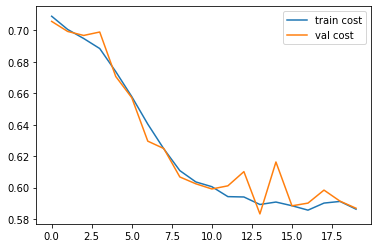

In [37]:
import matplotlib.pyplot as plt

plt.plot(rn.cost_history)
plt.plot(rn.val_cost_history)
plt.legend(['train cost', 'val cost'])
plt.show()

In [38]:
rn.score(x_val_onehot, y_val)

0.6848